## This is a script to solve for the motion of a massive rod double pendulum using DCA

#### Imports

In [1]:
import numpy as np
import scipy as sc
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import MBstructs as MB
import MultiBodyFuncts as MBF
import DCA

%matplotlib inline

#### Helper Functions

In [2]:
# This function prepares the system for the DCA algorithm 
def initialize(b,x,n):
    val1=0
    val2=np.zeros((3))
    val3=np.zeros((3))
    for k in range(0,n):
        val1=val1+x[k]
        b[k].C0=MBF.simdcm(val1,np.array((0,0,1)))
        val2=val2+np.array((0,0,x[k+n]))
        b[k].w=val2
        b[k].w1=np.array((0,0,x[k+n]))
        b[k].rs(b[k].l/2.0,np.array((0,-1,0)))
        b[k].Vcm=val3+np.cross(b[k].w,b[k].r10)
        val3=val3+np.cross(b[k].w,b[k].r12)
        b[k].Inertia2()#transformed inertia matrix
        b[k].Mmatrix()#Mass matrix and its inverse
        b[k].Forces(np.array((0,-1,0)))
        b[k].shifters()#S matrices
        b[k].zs()#zeta values

In [3]:
def simulate(state,t,n,i,bbs,jjs,BC1,BC2):
#     This function extracts the generalized coordinates from the solution of the equations of motion 
#     after calling the DCA to solve the equations of motion 

    #Initialize the system
    initialize(bbs,state,n)
    
    #Call the Recursive DCA Algorithm
    #This returns a list of the form:
    #[A11,A12,A21,A22,...,An1,An2]
    #where Axy corresponds to the acceleration
    #of the yth handle of the xth body
    ll=DCA.openR(n,0,bbs,jjs,BC1,BC2)

    #loop to fill d_dt with the acceleration values
    d_dt=np.zeros((2*n))
    for j in range(0,n):
        if j == 0:
            A1=ll.pop(0)
            d_dt[j+n]=np.dot(np.transpose(jjs[j].P),A1)
        else:
            A2= ll.pop(0)
            A1=ll.pop(0)
            d_dt[j+n]=np.dot(np.transpose(jjs[j].P),(A1-A2))
    
    #add the velocities to d_dt and return to the integrator
    d_dt[:n]=state[n:]
    return d_dt 

#### System specifications and Initial Conditions

In [4]:
# Specify number of bodies
n=22

# q1 and q2 are measured as the angle the rod makes with -n2 axis
q_init=np.zeros((n))
q_init[0]=np.pi/2

qdot_init=np.zeros((n))

ic=np.zeros((2*n))
ic[:n]=q_init
ic[n:]=qdot_init

#Length of time of the simulation
Time=np.arange(0,5,.01)

#### System Initialization

In [5]:
# # Create a list of Bodies and Joints
# bs=[]
# js=[]

# for i in range(0,n):
#     bs.append(MB.Body())
#     js.append(MB.Joint())

# # Joint Properties
# for joint in js:
#     joint.PDmatrix(np.array((0,0,1,0,0,0)),1)

# # Body Properties
# for i in range (0,n):
#     bs[i].m=1.0
#     bs[i].l=1.0
#     bs[i].Inertia(bs[i].m*(bs[i].l**2)/12,1,bs[i].m*(bs[i].l**2)/12)
# Create a list of Bodies and Joints
bs=[]
js=[]

for i in range(0,n):
    bs.append(MB.Body())
    js.append(MB.Joint(np.array([0,0,1,0,0,0]),1))

# Body Properties
for i in range (0,n):
    bs[i].m=1.0
    bs[i].l=1.0
    bs[i].Inertia(bs[i].m*(bs[i].l**2)/12,1,bs[i].m*(bs[i].l**2)/12)

In [6]:
initialize(bs,ic,n)

#### Simulate it

In [7]:
# odeint is the numerical integrator used
yy=odeint(simulate,ic,Time,(n,0,bs,js,2,1))

#### Check Results and Plot

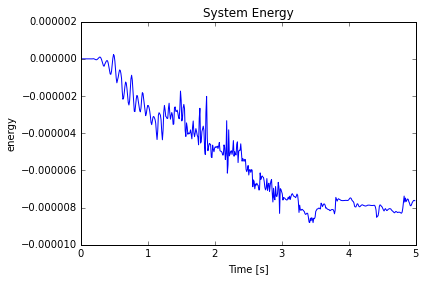

<function matplotlib.pyplot.show>

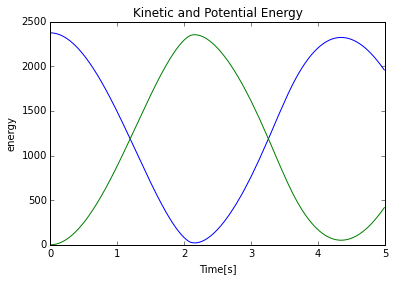

In [8]:
# The energy of the system is calculated and plotted
energy=MBF.PendEnergy(yy,bs)
KE=energy[:,0]
PE=energy[:,1]
TE=energy[:,2]

plt.plot(Time,TE-TE[0])
plt.xlabel("Time [s]")
plt.ylabel("energy")
plt.title("System Energy")
plt.show()

plt.plot(Time,PE,Time,KE)
plt.xlabel("Time[s]")
plt.ylabel("energy")
plt.title("Kinetic and Potential Energy")
plt.show

In [9]:
# Pot Generalized Coordinates
# plt.plot(Time,yy[:,:n])
# plt.xlabel("Time [s]")
# plt.ylabel("Generalized Coordinates [Rad]")
# plt.title("System Response")

# plt.show()

# plt.plot(Time,yy[:,n:])
# plt.xlabel(("Time[s]"))
# plt.ylabel(("Generalized Speeds [Rad/s]"))
# plt.title("System Response")

# plt.show()

In [10]:
np.shape(js[0].P)

(6, 1)

In [11]:
js[0].P.reshape((6,))

array([ 0.,  0.,  1.,  0.,  0.,  0.])